In [11]:
!git clone https://github.com/lydialydia-lydia/uniswap_v3_3pools_analysis.git
!ls -lah uniswap_v3_3pools_analysis/data


import pandas as pd
path = "uniswap_v3_3pools_analysis/data/dune_copy.xlsx"
df = pd.read_excel(path)

df.head()

fatal: destination path 'uniswap_v3_3pools_analysis' already exists and is not an empty directory.
total 36K
drwxr-xr-x 2 root root 4.0K Mar  1 18:19 .
drwxr-xr-x 4 root root 4.0K Mar  1 18:19 ..
-rw-r--r-- 1 root root  23K Mar  1 18:19 dune_copy.xlsx
-rw-r--r-- 1 root root    1 Mar  1 18:19 .gitkeep


,date,pool_name,num_swaps,volume_usd,estimated_fees_usd
0,2026-02-09,DAI/USDC 0.01%,176,2.461481e+06,246.148126
1,2026-02-09,USDC/ETH 0.05%,5791,1.945354e+08,97267.712780
2,2026-02-09,WETH/WBTC 0.05%,1585,1.690676e+07,8453.380784
3,2026-02-08,DAI/USDC 0.01%,351,1.778090e+07,1778.089792
4,2026-02-08,USDC/ETH 0.05%,7699,2.457567e+08,122878.330621


In [12]:
import requests
url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
r = requests.get(url, params={"vs_currency":"usd","days":90,"interval":"daily"})
print(r.status_code)
print(list(r.json().keys()))
print(r.json()["prices"][:2])

200
['prices', 'market_caps', 'total_volumes']
[[1764633600000, 2799.0367919901605], [1764720000000, 2995.751149322771]]


## A) Volatility

I analyze price risk over the past 90 days for three Uniswap V3 pools: **USDC/ETH (0.05%)**, **DAI/USDC (0.01%)**, and **WETH/WBTC (0.05%)**. I chose these because they represent three distinct market profiles: **volatile vs stable** (USDC/ETH), **stable vs stable** (DAI/USDC), and **volatile vs volatile / relative-price risk** (WETH/WBTC). Using CoinGecko daily spot prices as a proxy for pool price dynamics, I compute **realized volatility** (30d/90d annualized), **maximum drawdown**, and **tail moves** (worst 1-day and 7-day returns). This establishes a risk baseline for comparing fee stability and out-of-range behavior in later sections.

The following build a daily price proxy for three Uniswap V3 pools using CoinGecko spot prices (USD) and quantify the market risk environment; compute realized volatility (30d/90d annualized), max drawdown, and tail moves (worst 1d/7d returns); check BTC–ETH return correlation to understand relative-price risk for WETH/WBTC.
The goal is to compare how “risky” each pool’s price dynamics are before linking fees and range/out-of-range behavior in later sections.

In [ ]:
# A) Volatility (Risk Regime) — Setup & Data Fetch

import time, random
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)

def cg_market_chart(
    coin_id: str,
    vs: str = "usd",
    days: int = 180,
    interval: str = "daily",
    max_retries: int = 8,
    base_sleep: float = 1.0
) -> pd.DataFrame:
    """
    Fetch CoinGecko market_chart daily prices.
    Output columns: date, price

    Why this function:
    - CoinGecko free endpoint may return 429 (rate limit) or temporary 5xx errors.
    - We implement exponential backoff to be robust.
    """
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {"vs_currency": vs, "days": days, "interval": interval}

    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(url, params=params, timeout=30)

            # Rate limit / temporary errors
            if r.status_code in (429, 502, 503, 504):
                sleep = base_sleep * (2 ** (attempt - 1)) + random.uniform(0, 1.0)
                print(f"[{coin_id}] status={r.status_code}, retry in {sleep:.1f}s (attempt {attempt}/{max_retries})")
                time.sleep(sleep)
                continue

            r.raise_for_status()
            j = r.json()

            data = j.get("prices", [])  # [[ts_ms, price], ...]
            df = pd.DataFrame(data, columns=["ts_ms", "price"])

            # Convert timestamp to daily date
            df["date"] = pd.to_datetime(df["ts_ms"], unit="ms").dt.date
            df = df.drop(columns=["ts_ms"]).drop_duplicates("date").sort_values("date").reset_index(drop=True)

            df["date"] = pd.to_datetime(df["date"])  # normalize to datetime
            return df

        except Exception as e:
            last_err = e
            sleep = base_sleep * (2 ** (attempt - 1)) + random.uniform(0, 1.0)
            print(f"[{coin_id}] error={type(e).__name__}: {e}. retry in {sleep:.1f}s")
            time.sleep(sleep)

    raise RuntimeError(f"Failed to fetch {coin_id} after {max_retries} retries. Last error: {last_err}")

In [ ]:
# A) Fetch prices and build pool price proxies
DAYS_FETCH = 180  # use >90 so rolling-90d volatility is a curve (not a single point)

eth  = cg_market_chart("ethereum", days=DAYS_FETCH).rename(columns={"price": "ETH_USD"})
wbtc = cg_market_chart("wrapped-bitcoin", days=DAYS_FETCH).rename(columns={"price": "WBTC_USD"})
dai  = cg_market_chart("dai", days=DAYS_FETCH).rename(columns={"price": "DAI_USD"})
usdc = cg_market_chart("usd-coin", days=DAYS_FETCH).rename(columns={"price": "USDC_USD"})

# Merge into one daily table
prices = (
    eth.merge(wbtc, on="date")
       .merge(dai, on="date")
       .merge(usdc, on="date")
       .sort_values("date")
       .reset_index(drop=True)
)

# Build pool price proxies (approximate pool price series)
prices["USDC_ETH_0.05"]  = prices["ETH_USD"]                     # ETH priced in USD ~ ETH priced in USDC
prices["DAI_USDC_0.01"]  = prices["DAI_USD"] / prices["USDC_USD"]  # more precise than DAI_USD alone
prices["WETH_WBTC_0.05"] = prices["ETH_USD"] / prices["WBTC_USD"]  # ETH per BTC (relative price)

pool_cols = {
    "USDC/ETH 0.05%":  "USDC_ETH_0.05",
    "DAI/USDC 0.01%":  "DAI_USDC_0.01",
    "WETH/WBTC 0.05%": "WETH_WBTC_0.05",
}

display(prices.head())

[dai] status=429, retry in 1.1s (attempt 1/8)
[dai] status=429, retry in 2.1s (attempt 2/8)
[dai] status=429, retry in 4.5s (attempt 3/8)
[dai] status=429, retry in 8.7s (attempt 4/8)
[dai] status=429, retry in 17.0s (attempt 5/8)
[dai] status=429, retry in 32.2s (attempt 6/8)
[dai] status=429, retry in 64.2s (attempt 7/8)


,ETH_USD,date,WBTC_USD,DAI_USD,USDC_USD,USDC_ETH_0.05,DAI_USDC_0.01,WETH_WBTC_0.05
0,4325.856306,2025-09-03,111138.275495,0.998479,0.999715,4325.856306,0.998763,0.038923
1,4449.867098,2025-09-04,111674.705049,1.000935,0.999802,4449.867098,1.001133,0.039847
2,4298.094661,2025-09-05,110727.568066,0.999804,0.999810,4298.094661,0.999993,0.038817
3,4306.613513,2025-09-06,110493.210218,0.999320,0.999806,4306.613513,0.999514,0.038976
4,4273.110024,2025-09-07,110272.673775,0.999961,0.999843,4273.110024,1.000118,0.038750


The proxy series behave as expected across pool types. DAI/USDC stays tightly around 1.0, indicating minimal basis risk and suggesting out-of-range risk should be low for reasonable bands. USDC/ETH (proxied by ETH_USD) moves at a completely different scale and shows large directional swings, consistent with a volatile/stable pair where price trends can quickly push concentrated liquidity out of range. WETH/WBTC (ETH_USD/WBTC_USD) sits around ~0.03–0.04, reflecting relative-price dynamics; compared with ETH_USD, it should be structurally less volatile because shared “crypto market” moves in ETH and BTC partially cancel in the ratio.


In [ ]:
# A) Risk metrics: realized vol, max drawdown, tail moves, correlation

def log_returns(px: pd.Series) -> pd.Series:
    """Daily log returns."""
    px = px.astype(float)
    return np.log(px).diff()

def ann_realized_vol(px: pd.Series, window: int, ann_factor: int = 365) -> pd.Series:
    """
    Rolling annualized realized volatility using log returns.
    vol_t = std(log_returns over rolling window) * sqrt(365)
    """
    r = log_returns(px)
    return r.rolling(window=window, min_periods=window).std(ddof=0) * np.sqrt(ann_factor)

def max_drawdown(px: pd.Series) -> float:
    """Maximum drawdown over the whole series."""
    px = px.astype(float)
    running_max = px.cummax()
    dd = px / running_max - 1.0
    return float(dd.min())

def worst_1d_return(px: pd.Series) -> float:
    """Worst single-day simple return."""
    r = px.pct_change()
    return float(r.min())

def worst_7d_return(px: pd.Series) -> float:
    """Worst 7-day simple return."""
    r7 = px / px.shift(7) - 1.0
    return float(r7.min())

def corr_returns(px_a: pd.Series, px_b: pd.Series) -> float:
    """Correlation between log returns of two price series."""
    ra = log_returns(px_a)
    rb = log_returns(px_b)
    return float(pd.concat([ra, rb], axis=1).dropna().corr().iloc[0, 1])

# Build summary table for the 3 pools
rows = []
for pool, col in pool_cols.items():
    px = prices[col].dropna()

    rows.append({
        "pool": pool,
        "last_price": float(px.iloc[-1]),
        "rv_30d_ann": float(ann_realized_vol(px, window=30).iloc[-1]),
        "rv_90d_ann": float(ann_realized_vol(px, window=90).iloc[-1]),
        "max_drawdown": max_drawdown(px),
        "worst_1d_return": worst_1d_return(px),
        "worst_7d_return": worst_7d_return(px),
        "n_days": int(px.shape[0]),
    })

summary_A = pd.DataFrame(rows).sort_values("pool").reset_index(drop=True)

# Correlation between WBTC and ETH (log returns)
summary_A["corr_WBTC_vs_ETH_logret"] = corr_returns(prices["WBTC_USD"], prices["ETH_USD"])

display(summary_A)

,pool,last_price,rv_30d_ann,rv_90d_ann,max_drawdown,worst_1d_return,worst_7d_return,n_days,corr_WBTC_vs_ETH_logret
0,DAI/USDC 0.01%,0.999681,0.027238,0.020044,-0.006388,-0.004351,-0.004711,180,0.903426
1,USDC/ETH 0.05%,1965.036620,1.037556,0.774341,-0.613372,-0.154045,-0.354137,180,0.903426
2,WETH/WBTC 0.05%,0.029442,0.392591,0.328331,-0.292361,-0.056844,-0.131202,180,0.903426


The risk metrics separate the pools into clear tiers. USDC/ETH is the dominant risk driver: its 1.0 annualized 30D volatility, 61% max drawdown, and large tail losses (≈15% worst day, ≈35% worst week) imply frequent regime shifts and a high likelihood of fee income becoming unreliable for narrow ranges (out-of-range risk and IL exposure both rise in these conditions).

DAI/USDC is effectively “carry-like”: low vol (2–3% ann), shallow drawdown (<1%), and small tail moves, so range feasibility should be consistently high and IL baseline negligible.

WETH/WBTC sits in between: moderate vol (0.33–0.39 ann) and smaller tail risk than USDC/ETH, which aligns with the high ETH–BTC return correlation (0.90) reducing relative-price volatility; however, the 29% drawdown shows that correlation is not a full hedge, so relative-value regimes (correlation breaks) remain an important stress scenario.

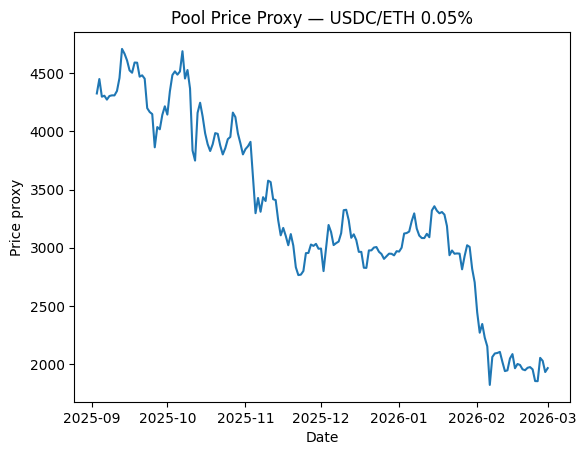

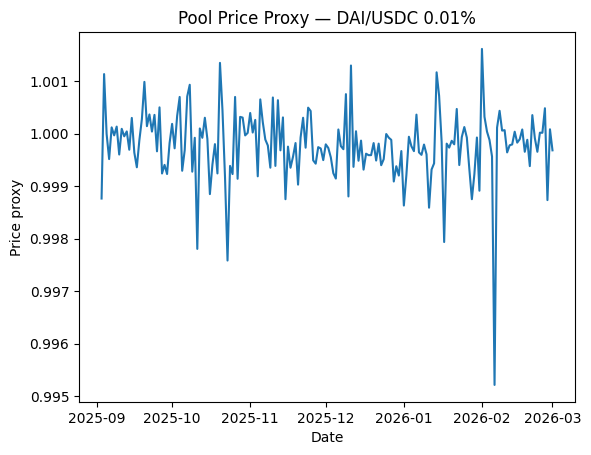

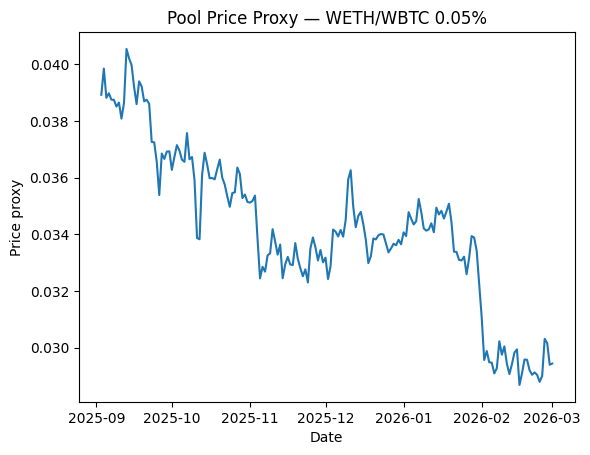

In [13]:
# A) Plots
# 1) Price proxy per pool (separate plots avoids scale issues)
# 2) Rolling realized vol (30d, 90d)

# 1) Price proxy: plot separately to avoid "flat line" due to different scales
for pool, col in pool_cols.items():
    plt.figure()
    plt.plot(prices["date"], prices[col])
    plt.title(f"Pool Price Proxy — {pool}")
    plt.xlabel("Date")
    plt.ylabel("Price proxy")
    plt.show()

USDC/ETH 0.05% (ETH/USD proxy): The series shows a clear downtrend from approximately 4,500 to around 2,000, with several sharp swings and a deep drawdown. This is a high-volatility environment where a narrow, non-rebalanced V3 range would likely go out-of-range quickly, making fee capture more regime-dependent.


DAI/USDC 0.01% (stablecoin basis): The price proxy stays tightly anchored around 1.00, with only small, brief deviations (including one noticeable dip to about 0.995). This indicates low price risk and high range feasibility—out-of-range risk should be minimal for typical bands.

WETH/WBTC 0.05% (ETH/BTC relative price): The relative price declines from approximately 0.039 to around 0.029, with moderate fluctuations. This reflects meaningful relative-value risk (ETH underperforming BTC over the sample), with out-of-range risk present but generally less extreme than the USDC/ETH pool.

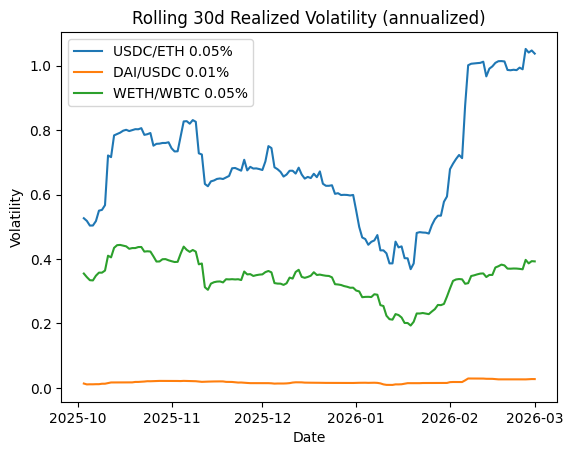

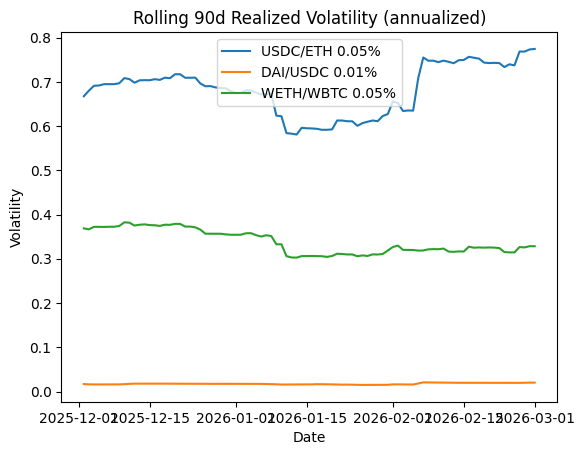

In [ ]:
# 2) Rolling realized volatility: 30d and 90d
for window in [30, 90]:
    plt.figure()
    for pool, col in pool_cols.items():
        rv = ann_realized_vol(prices[col], window=window)
        plt.plot(prices["date"], rv, label=pool)
    plt.title(f"Rolling {window}d Realized Volatility (annualized)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()

Rolling 30d realized volatility (annualized): USDC/ETH has the highest and most time-varying volatility, with a clear surge toward the end of the sample—consistent with a “high-vol regime” emerging. WETH/WBTC sits in the middle with a noticeable dip around mid-period and a gradual rebound, while DAI/USDC remains near zero throughout, reflecting stablecoin behavior.

Rolling 90d realized volatility (annualized): The same ranking holds (USDC/ETH > WETH/WBTC >> DAI/USDC), but the series are much smoother because the window is longer. USDC/ETH shows a step-up later in the period, indicating a sustained volatility shift rather than a brief spike. WETH/WBTC remains comparatively stable in a moderate band, suggesting relative-price risk is present but less extreme than ETH/USD over longer horizons.


## B) Fee Rate & Stability

Use Dune daily pool table (date, swaps, USD volume, and estimated fees) and compute pool-level fee quality metrics. For each pool, derive daily **fee_rate** (fees/volume) and **fees_per_swap**, and measure stability using **CV (std/mean)** and **7-day rolling fee sums** to capture weekly peaks/troughs (best vs worst week).

In [24]:
# B) Load & clean Dune daily pool table
# Expected columns (after cleaning):
#   date, pool_name, num_swaps, volume_usd, estimated_fees_usd

import pandas as pd
import numpy as np

PATH = "uniswap_v3_3pools_analysis/data/dune_copy.xlsx"

df = pd.read_excel(PATH)

# Standardize column names (strip spaces, lower)
df.columns = [str(c).strip().lower() for c in df.columns]

# Fix common typos from your screenshots:
rename_map = {
    "volumn_usd": "volume_usd",            # typo in some exports
    "estiamted_fees_usd": "estimated_fees_usd",
}
df = df.rename(columns=rename_map)

# Ensure required columns exist
required = ["date", "pool_name", "num_swaps", "volume_usd", "estimated_fees_usd"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in Dune.xlsx: {missing}. Got: {df.columns.tolist()}")

# Parse types
df["date"] = pd.to_datetime(df["date"]).dt.normalize()
for c in ["num_swaps", "volume_usd", "estimated_fees_usd"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=required).sort_values(["pool_name", "date"]).reset_index(drop=True)

display(df.head())
print("Pools found:", df["pool_name"].unique())
print("Rows:", len(df))

,date,pool_name,num_swaps,volume_usd,estimated_fees_usd
0,2025-11-11,DAI/USDC 0.01%,54,4.387348e+06,438.734813
1,2025-11-12,DAI/USDC 0.01%,187,2.045537e+06,204.553684
2,2025-11-13,DAI/USDC 0.01%,330,2.050744e+06,205.074379
3,2025-11-14,DAI/USDC 0.01%,247,4.883887e+06,488.388705
4,2025-11-15,DAI/USDC 0.01%,188,5.443212e+06,544.321169


Pools found: ['DAI/USDC 0.01%' 'USDC/ETH 0.05%' 'WETH/WBTC 0.05%']
Rows: 273


In [25]:
# B) Fee rate + fee stability (per pool)
# Metrics:
#   fee_rate = fees / volume
#   fees_per_swap = fees / num_swaps
#   fees volatility = std / mean (CV)
#   worst week fees = min(rolling 7d sum of fees)
# Output:
#   - 1 summary table per pool (kept short)
#   - a compact overall summary table
#   - plots: daily fees and 7d rolling fees per pool

import matplotlib.pyplot as plt

d = df.copy()

# Daily derived metrics
d["fee_rate"] = d["estimated_fees_usd"] / d["volume_usd"]
d["fees_per_swap"] = d["estimated_fees_usd"] / d["num_swaps"].replace(0, np.nan)

# 7d rolling fee sum per pool
d["fees_7d_sum"] = d.groupby("pool_name")["estimated_fees_usd"].transform(lambda s: s.rolling(7).sum())

def cv(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) == 0:
        return np.nan
    m = x.mean()
    return float(x.std(ddof=0) / m) if m != 0 else np.nan

summaries = []
tables_by_pool = {}

for pool, g in d.groupby("pool_name"):
    g = g.sort_values("date").reset_index(drop=True)

    pool_summary = pd.DataFrame([{
        "pool_name": pool,
        "days": int(g["date"].nunique()),
        "total_volume": float(g["volume_usd"].sum()),
        "total_fees": float(g["estimated_fees_usd"].sum()),
        "avg_daily_volume": float(g["volume_usd"].mean()),
        "avg_daily_fees": float(g["estimated_fees_usd"].mean()),
        "fee_rate_mean": float(g["fee_rate"].mean()),
        "fee_rate_cv": cv(g["fee_rate"]),
        "fees_cv": cv(g["estimated_fees_usd"]),
        "worst_week_fees": float(g["fees_7d_sum"].min()) if g["fees_7d_sum"].notna().any() else np.nan,
        "best_week_fees": float(g["fees_7d_sum"].max()) if g["fees_7d_sum"].notna().any() else np.nan,
        "avg_fees_per_swap": float(g["fees_per_swap"].mean()),
    }])

    summaries.append(pool_summary)

    # Keep a short “daily preview table”
    daily_preview = g[["date","pool_name","num_swaps","volume_usd","estimated_fees_usd","fee_rate","fees_per_swap","fees_7d_sum"]].tail(15)
    tables_by_pool[pool] = {"summary": pool_summary, "daily_tail_15": daily_preview}

overall = pd.concat(summaries, ignore_index=True).sort_values("pool_name").reset_index(drop=True)

print("=== Overall summary (all pools) ===")
display(overall)

=== Overall summary (all pools) ===


,pool_name,days,total_volume,total_fees,avg_daily_volume,avg_daily_fees,fee_rate_mean,fee_rate_cv,fees_cv,worst_week_fees,best_week_fees,avg_fees_per_swap
0,DAI/USDC 0.01%,91,3.728313e+08,3.728313e+04,4.097047e+06,409.704719,0.0001,4.651542e-16,1.589000,491.548000,9.237712e+03,1.728914
1,USDC/ETH 0.05%,91,7.258660e+09,3.629330e+06,7.976549e+07,39882.747434,0.0005,2.348680e-15,1.930220,62387.886729,1.695836e+06,5.288397
2,WETH/WBTC 0.05%,91,2.276909e+09,1.138454e+06,2.502098e+07,12510.488191,0.0005,2.520586e-15,0.912221,47062.905361,2.745060e+05,4.614481


Over the 91-day window, USDC/ETH 0.05% dominates in scale: it has the highest total and average daily volume (about 79.8M/day) and the highest average daily fees (about 39.9K/day), with a very wide dispersion between best and worst weeks (about 1.70M vs 62.4K), indicating strong fee cyclicality/regime dependence. WETH/WBTC 0.05% is the second-largest by activity (about 25.0M/day volume; 12.5K/day fees) and shows the lowest fee variability among the volatile pairs (fees_cv ≈ 0.91), suggesting more stable fee generation in this sample. DAI/USDC 0.01% behaves like a low-risk carry pool: low fees (about 410/day) and lower volumes, with fee_rate_mean matching its tier (0.01%) and smaller weekly fee magnitudes overall. Across pools, the implied fee_rate_mean aligns with the fee tiers (0.0001 vs 0.0005), and avg_fees_per_swap is higher for the volatile pairs, consistent with larger trade sizes and/or more fee-intensive flow.

In [26]:
print("\n=== Per-pool tables (short) ===")
for pool, pack in tables_by_pool.items():
    print(f"\n--- {pool}: summary ---")
    display(pack["summary"])
    print(f"--- {pool}: last 15 days preview ---")
    display(pack["daily_tail_15"])


=== Per-pool tables (short) ===

--- DAI/USDC 0.01%: summary ---


,pool_name,days,total_volume,total_fees,avg_daily_volume,avg_daily_fees,fee_rate_mean,fee_rate_cv,fees_cv,worst_week_fees,best_week_fees,avg_fees_per_swap
0,DAI/USDC 0.01%,91,3.728313e+08,37283.129467,4.097047e+06,409.704719,0.0001,4.651542e-16,1.589,491.548,9237.711719,1.728914


--- DAI/USDC 0.01%: last 15 days preview ---


,date,pool_name,num_swaps,volume_usd,estimated_fees_usd,fee_rate,fees_per_swap,fees_7d_sum
76,2026-01-26,DAI/USDC 0.01%,152,1.685942e+06,168.594193,0.0001,1.109172,946.376485
77,2026-01-27,DAI/USDC 0.01%,174,8.444791e+05,84.447911,0.0001,0.485333,922.353172
78,2026-01-28,DAI/USDC 0.01%,99,2.291588e+05,22.915879,0.0001,0.231474,782.650930
79,2026-01-29,DAI/USDC 0.01%,428,5.618020e+06,561.802045,0.0001,1.312622,1283.756057
80,2026-01-30,DAI/USDC 0.01%,260,6.478520e+06,647.852029,0.0001,2.491739,1822.560642
81,2026-01-31,DAI/USDC 0.01%,431,8.937111e+06,893.711071,0.0001,2.073576,2450.266847
82,2026-02-01,DAI/USDC 0.01%,332,4.416945e+06,441.694464,0.0001,1.330405,2821.017591
83,2026-02-02,DAI/USDC 0.01%,297,5.108708e+06,510.870824,0.0001,1.720104,3163.294222
84,2026-02-03,DAI/USDC 0.01%,241,2.220007e+06,222.000709,0.0001,0.921165,3300.847021
85,2026-02-04,DAI/USDC 0.01%,257,5.090122e+06,509.012193,0.0001,1.980592,3786.943335



--- USDC/ETH 0.05%: summary ---


,pool_name,days,total_volume,total_fees,avg_daily_volume,avg_daily_fees,fee_rate_mean,fee_rate_cv,fees_cv,worst_week_fees,best_week_fees,avg_fees_per_swap
0,USDC/ETH 0.05%,91,7.258660e+09,3.629330e+06,7.976549e+07,39882.747434,0.0005,2.348680e-15,1.93022,62387.886729,1.695836e+06,5.288397


--- USDC/ETH 0.05%: last 15 days preview ---


,date,pool_name,num_swaps,volume_usd,estimated_fees_usd,fee_rate,fees_per_swap,fees_7d_sum
76,2026-01-26,USDC/ETH 0.05%,4572,2.669436e+07,13347.181921,0.0005,2.919331,1.278646e+05
77,2026-01-27,USDC/ETH 0.05%,4355,2.716542e+07,13582.708592,0.0005,3.118877,1.158319e+05
78,2026-01-28,USDC/ETH 0.05%,3656,4.387914e+07,21939.569574,0.0005,6.000976,1.068844e+05
79,2026-01-29,USDC/ETH 0.05%,5185,4.422613e+07,22113.067476,0.0005,4.264815,1.033680e+05
80,2026-01-30,USDC/ETH 0.05%,6733,1.387225e+08,69361.238892,0.0005,10.301684,1.600910e+05
81,2026-01-31,USDC/ETH 0.05%,9466,1.482248e+08,74112.412370,0.0005,7.829327,2.311120e+05
82,2026-02-01,USDC/ETH 0.05%,8077,7.110124e+07,35550.617841,0.0005,4.401463,2.500068e+05
83,2026-02-02,USDC/ETH 0.05%,9648,1.885454e+08,94272.717467,0.0005,9.771219,3.309323e+05
84,2026-02-03,USDC/ETH 0.05%,8286,1.605967e+08,80298.360225,0.0005,9.690847,3.976480e+05
85,2026-02-04,USDC/ETH 0.05%,9392,3.946016e+08,197300.811294,0.0005,21.007327,5.730092e+05



--- WETH/WBTC 0.05%: summary ---


,pool_name,days,total_volume,total_fees,avg_daily_volume,avg_daily_fees,fee_rate_mean,fee_rate_cv,fees_cv,worst_week_fees,best_week_fees,avg_fees_per_swap
0,WETH/WBTC 0.05%,91,2.276909e+09,1.138454e+06,2.502098e+07,12510.488191,0.0005,2.520586e-15,0.912221,47062.905361,274505.96717,4.614481


--- WETH/WBTC 0.05%: last 15 days preview ---


,date,pool_name,num_swaps,volume_usd,estimated_fees_usd,fee_rate,fees_per_swap,fees_7d_sum
76,2026-01-26,WETH/WBTC 0.05%,2548,2.196900e+07,10984.502237,0.0005,4.311029,65267.325366
77,2026-01-27,WETH/WBTC 0.05%,1873,1.545830e+07,7729.147586,0.0005,4.126614,61991.068397
78,2026-01-28,WETH/WBTC 0.05%,1938,1.599064e+07,7995.317884,0.0005,4.125551,57582.363916
79,2026-01-29,WETH/WBTC 0.05%,2172,3.456100e+07,17280.502184,0.0005,7.956032,66022.456038
80,2026-01-30,WETH/WBTC 0.05%,2796,4.151653e+07,20758.267272,0.0005,7.424273,79112.919426
81,2026-01-31,WETH/WBTC 0.05%,4361,7.937504e+07,39687.517855,0.0005,9.100554,116731.313928
82,2026-02-01,WETH/WBTC 0.05%,3993,4.132258e+07,20661.288702,0.0005,5.174377,125096.543720
83,2026-02-02,WETH/WBTC 0.05%,4458,4.038028e+07,20190.137981,0.0005,4.528968,134302.179464
84,2026-02-03,WETH/WBTC 0.05%,3940,4.478729e+07,22393.643452,0.0005,5.683666,148966.675330
85,2026-02-04,WETH/WBTC 0.05%,3817,5.267693e+07,26338.463077,0.0005,6.900305,167309.820524


DAI/USDC 0.01%: Fees are small in absolute terms (about $410/day on average) and the implied fee rate is essentially constant at 0.01%, which is expected for a stablecoin pair. The last-15-days view shows day-to-day fees mainly track volume, with occasional volume spikes driving higher fees, but overall this pool looks like a low-risk, low-revenue “carry” baseline.

USDC/ETH 0.05%: This pool has the largest activity and fee generation, but it is also the most cyclical: daily fees vary widely and the 7-day rolling sum ramps up sharply in the last-15-days window (a clear “hot market” episode). The implied fee rate stays near 0.05%, so the swings are driven by volume/flow regime changes rather than fee-rate drift—good upside, but fee income is more regime-dependent.

WETH/WBTC 0.05%: Fees and volume sit between the other two pools, with a more moderate profile than USDC/ETH. In the last-15-days preview, fees_per_swap and the 7-day fee sum rise during active periods, but variability is less extreme than USDC/ETH, suggesting more stable fee generation while still benefiting from risk-on bursts.

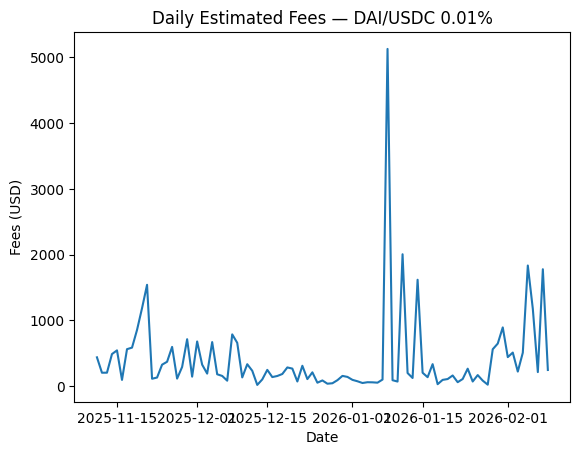

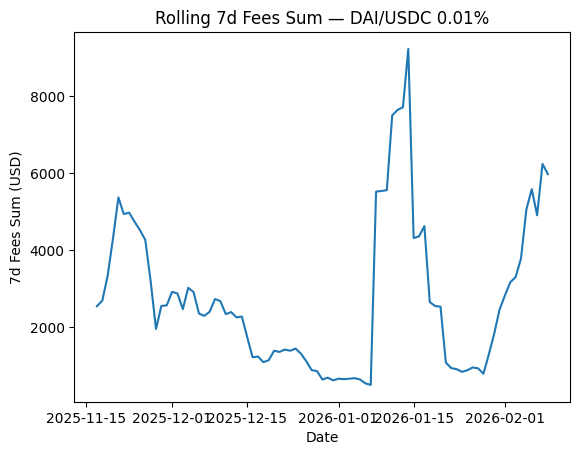

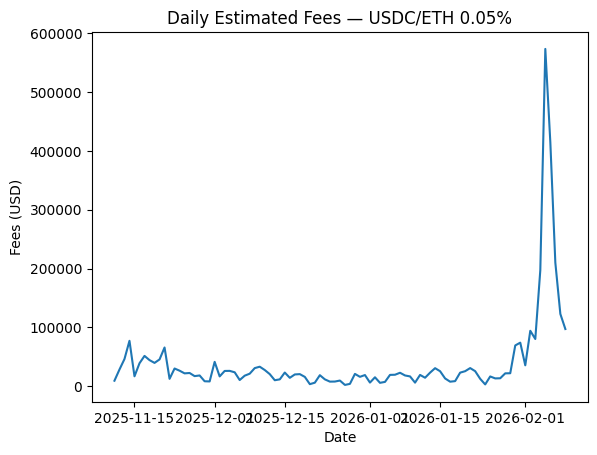

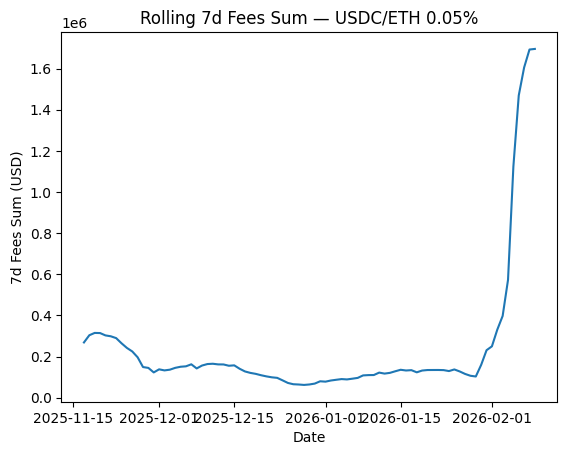

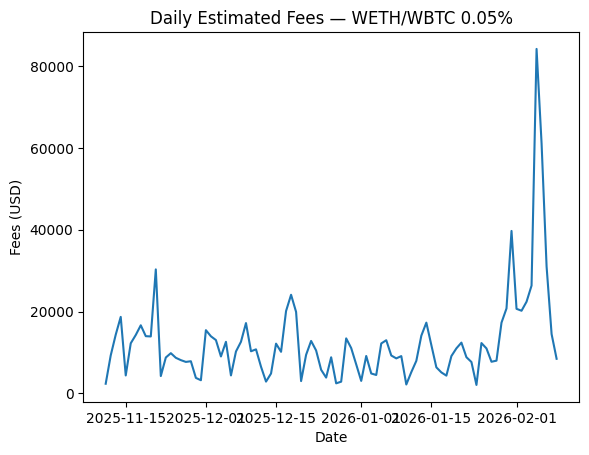

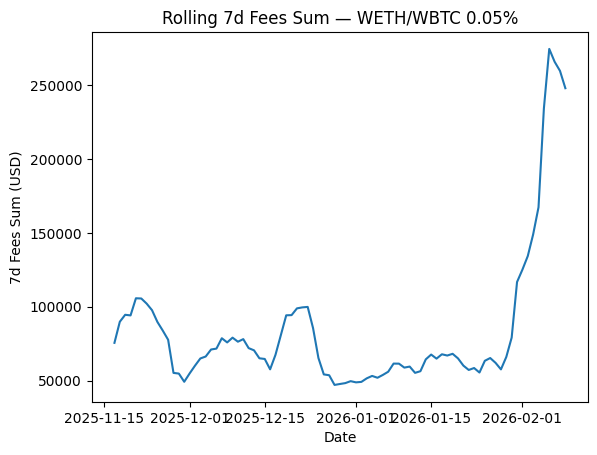

In [27]:
# Plots (per pool)
for pool, g in d.groupby("pool_name"):
    g = g.sort_values("date")
    plt.figure()
    plt.plot(g["date"], g["estimated_fees_usd"])
    plt.title(f"Daily Estimated Fees — {pool}")
    plt.xlabel("Date")
    plt.ylabel("Fees (USD)")
    plt.show()

    plt.figure()
    plt.plot(g["date"], g["fees_7d_sum"])
    plt.title(f"Rolling 7d Fees Sum — {pool}")
    plt.xlabel("Date")
    plt.ylabel("7d Fees Sum (USD)")
    plt.show()

DAI/USDC 0.01%: Daily fees are usually low and fairly steady, but there are a few sharp one-day spikes (notably in mid-January) that drive a temporary jump in the 7-day rolling sum. Outside those bursts, the rolling 7d fees trend lower into late December/early January and then recover gradually into early February—overall a “small but occasionally spiky” fee profile typical for a stablecoin pool.

USDC/ETH 0.05%: Fees are moderate for most of the window, then enter a clear late-period surge: daily fees ramp rapidly and culminate in a very large spike, and the rolling 7d sum accelerates sharply to a new peak. This is strong evidence of regime dependence—fee income is dominated by high-activity episodes rather than stable day-to-day accrual.

WETH/WBTC 0.05%: Daily fees show recurring bursts throughout the sample with a noticeable upswing toward the end, including a large spike in early February. The rolling 7d fees move in cycles (rise → cool down → rise again) and then step up materially in the final weeks, suggesting fees are more stable than USDC/ETH on average but still meaningfully driven by market/flow regimes.

#C) Impermanent Loss & Out-of-Range Risk

In [28]:
# C1) Time-in-range proxy for Uniswap V3
# Range strategies: ±5%, ±10%, ±20%
# How computed:
#   - Use daily price proxy series P_t
#   - Assume each day we "center" range at P_{t-1} (yesterday close) (simple re-center proxy)
#   - In-range at day t if P_t ∈ [P_{t-1}*(1-δ), P_{t-1}*(1+δ)]
#   - time_in_range = mean(in_range_flag)

import numpy as np
import pandas as pd

# prices columns needed: date + (USDC_ETH_0.05, DAI_USDC_0.01, WETH_WBTC_0.05)
pool_cols = {
    "USDC/ETH 0.05%": "USDC_ETH_0.05",
    "DAI/USDC 0.01%": "DAI_USDC_0.01",
    "WETH/WBTC 0.05%": "WETH_WBTC_0.05",
}

RANGES = [0.05, 0.10, 0.20]  # ±5%, ±10%, ±20%

tir_rows = []
tir_daily_all = []

for pool, col in pool_cols.items():
    tmp = prices[["date", col]].dropna().sort_values("date").reset_index(drop=True)
    tmp = tmp.rename(columns={col: "P"})

    tmp["P_prev"] = tmp["P"].shift(1)
    tmp = tmp.dropna(subset=["P_prev"]).reset_index(drop=True)

    for d in RANGES:
        lower = tmp["P_prev"] * (1 - d)
        upper = tmp["P_prev"] * (1 + d)
        in_range = ((tmp["P"] >= lower) & (tmp["P"] <= upper)).astype(int)

        tmp2 = tmp[["date"]].copy()
        tmp2["pool_name"] = pool
        tmp2["range_pct"] = d
        tmp2["in_range"] = in_range
        tir_daily_all.append(tmp2)

        tir_rows.append({
            "pool_name": pool,
            "range_pct": d,
            "time_in_range": float(in_range.mean()),
            "n_days_used": int(in_range.shape[0])
        })

tir_summary = pd.DataFrame(tir_rows).sort_values(["pool_name", "range_pct"]).reset_index(drop=True)
tir_daily = pd.concat(tir_daily_all, ignore_index=True)

display(tir_summary)
display(tir_daily.head())

,pool_name,range_pct,time_in_range,n_days_used
0,DAI/USDC 0.01%,0.05,1.000000,179
1,DAI/USDC 0.01%,0.10,1.000000,179
2,DAI/USDC 0.01%,0.20,1.000000,179
3,USDC/ETH 0.05%,0.05,0.832402,179
4,USDC/ETH 0.05%,0.10,0.972067,179
5,USDC/ETH 0.05%,0.20,1.000000,179
6,WETH/WBTC 0.05%,0.05,0.988827,179
7,WETH/WBTC 0.05%,0.10,1.000000,179
8,WETH/WBTC 0.05%,0.20,1.000000,179


,date,pool_name,range_pct,in_range
0,2025-09-04,USDC/ETH 0.05%,0.05,1
1,2025-09-05,USDC/ETH 0.05%,0.05,1
2,2025-09-06,USDC/ETH 0.05%,0.05,1
3,2025-09-07,USDC/ETH 0.05%,0.05,1
4,2025-09-08,USDC/ETH 0.05%,0.05,1


This table quantifies time-in-range (share of days the price stays within a ±range around the entry price) for three pools under ±5%, ±10%, and ±20% bands. DAI/USDC is in-range 100% of the time even at ±5%, consistent with stablecoin behavior and negligible out-of-range risk. USDC/ETH is the most sensitive to range width: at ±5% it is in-range only about 83% of days (meaning frequent out-of-range episodes), improving to about 97% at ±10% and reaching 100% at ±20%. WETH/WBTC is relatively stable in this sample: even ±5% stays in-range about 99% of days, and wider bands are effectively always in-range. Overall, narrower ranges are most fragile for USDC/ETH, while the other two pools exhibit high range feasibility over the period.

In [31]:
# C2) Range-adjusted fees proxy (no position-level needed)
# range_adjusted_fees = pool_daily_fees * in_range_flag
import numpy as np
import pandas as pd

# required: date, pool_name, estimated_fees_usd
fees = df[["date","pool_name","estimated_fees_usd","volume_usd","num_swaps"]].copy()
fees["date"] = pd.to_datetime(fees["date"]).dt.normalize()

# Join in_range flags (tir_daily) onto fees by (date, pool_name, range_pct)
c = fees.merge(tir_daily, on=["date","pool_name"], how="inner")

c["range_adjusted_fees"] = c["estimated_fees_usd"] * c["in_range"]
c["fees_7d_sum"] = c.groupby(["pool_name","range_pct"])["estimated_fees_usd"].transform(lambda s: s.rolling(7).sum())
c["range_adj_fees_7d_sum"] = c.groupby(["pool_name","range_pct"])["range_adjusted_fees"].transform(lambda s: s.rolling(7).sum())

# Summary per pool x range
def cv(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) == 0:
        return np.nan
    m = x.mean()
    return float(x.std(ddof=0) / m) if m != 0 else np.nan

summary_rows = []
for (pool, d), g in c.groupby(["pool_name","range_pct"]):
    summary_rows.append({
        "pool_name": pool,
        "range_pct": d,
        "time_in_range": float(g["in_range"].mean()),
        "total_fees_usd": float(g["estimated_fees_usd"].sum()),
        "total_range_adjusted_fees_usd": float(g["range_adjusted_fees"].sum()),
        "capture_ratio": float(g["range_adjusted_fees"].sum() / g["estimated_fees_usd"].sum()) if g["estimated_fees_usd"].sum() > 0 else np.nan,
        "avg_daily_range_adj_fees": float(g["range_adjusted_fees"].mean()),
        "range_adj_fees_cv": cv(g["range_adjusted_fees"]),
        "worst_week_range_adj_fees": float(g["range_adj_fees_7d_sum"].min()) if g["range_adj_fees_7d_sum"].notna().any() else np.nan,
        "best_week_range_adj_fees": float(g["range_adj_fees_7d_sum"].max()) if g["range_adj_fees_7d_sum"].notna().any() else np.nan,
        "n_days": int(g["date"].nunique())
    })

C2_summary = pd.DataFrame(summary_rows).sort_values(["pool_name","range_pct"]).reset_index(drop=True)
display(C2_summary)

# Optional: show a short table for one pool (last 15 days)
for pool in sorted(c["pool_name"].unique()):
    tmp = c[(c["pool_name"]==pool) & (c["range_pct"]==0.10)].sort_values("date").tail(15)
    print(f"\n--- {pool} (±10%) last 15 days ---")
    display(tmp[["date","estimated_fees_usd","in_range","range_adjusted_fees"]])

,pool_name,range_pct,time_in_range,total_fees_usd,total_range_adjusted_fees_usd,capture_ratio,avg_daily_range_adj_fees,range_adj_fees_cv,worst_week_range_adj_fees,best_week_range_adj_fees,n_days
0,DAI/USDC 0.01%,0.05,1.000000,3.728313e+04,3.728313e+04,1.000000,409.704719,1.589000,491.548000,9.237712e+03,91
1,DAI/USDC 0.01%,0.10,1.000000,3.728313e+04,3.728313e+04,1.000000,409.704719,1.589000,491.548000,9.237712e+03,91
2,DAI/USDC 0.01%,0.20,1.000000,3.728313e+04,3.728313e+04,1.000000,409.704719,1.589000,491.548000,9.237712e+03,91
3,USDC/ETH 0.05%,0.05,0.824176,3.629330e+06,2.275705e+06,0.627032,25007.743018,2.450117,62158.504688,8.737209e+05,91
4,USDC/ETH 0.05%,0.10,0.978022,3.629330e+06,3.004516e+06,0.827843,33016.655917,1.927835,62387.886729,1.124173e+06,91
5,USDC/ETH 0.05%,0.20,1.000000,3.629330e+06,3.629330e+06,1.000000,39882.747434,1.930220,62387.886729,1.695836e+06,91
6,WETH/WBTC 0.05%,0.05,1.000000,1.138454e+06,1.138454e+06,1.000000,12510.488191,0.912221,47062.905361,2.745060e+05,91
7,WETH/WBTC 0.05%,0.10,1.000000,1.138454e+06,1.138454e+06,1.000000,12510.488191,0.912221,47062.905361,2.745060e+05,91
8,WETH/WBTC 0.05%,0.20,1.000000,1.138454e+06,1.138454e+06,1.000000,12510.488191,0.912221,47062.905361,2.745060e+05,91



--- DAI/USDC 0.01% (±10%) last 15 days ---


,date,estimated_fees_usd,in_range,range_adjusted_fees
229,2026-01-26,168.594193,1,168.594193
232,2026-01-27,84.447911,1,84.447911
235,2026-01-28,22.915879,1,22.915879
238,2026-01-29,561.802045,1,561.802045
241,2026-01-30,647.852029,1,647.852029
244,2026-01-31,893.711071,1,893.711071
247,2026-02-01,441.694464,1,441.694464
250,2026-02-02,510.870824,1,510.870824
253,2026-02-03,222.000709,1,222.000709
256,2026-02-04,509.012193,1,509.012193



--- USDC/ETH 0.05% (±10%) last 15 days ---


,date,estimated_fees_usd,in_range,range_adjusted_fees
502,2026-01-26,13347.181921,1,13347.181921
505,2026-01-27,13582.708592,1,13582.708592
508,2026-01-28,21939.569574,1,21939.569574
511,2026-01-29,22113.067476,1,22113.067476
514,2026-01-30,69361.238892,1,69361.238892
517,2026-01-31,74112.412370,1,74112.412370
520,2026-02-01,35550.617841,1,35550.617841
523,2026-02-02,94272.717467,1,94272.717467
526,2026-02-03,80298.360225,1,80298.360225
529,2026-02-04,197300.811294,1,197300.811294



--- WETH/WBTC 0.05% (±10%) last 15 days ---


,date,estimated_fees_usd,in_range,range_adjusted_fees
775,2026-01-26,10984.502237,1,10984.502237
778,2026-01-27,7729.147586,1,7729.147586
781,2026-01-28,7995.317884,1,7995.317884
784,2026-01-29,17280.502184,1,17280.502184
787,2026-01-30,20758.267272,1,20758.267272
790,2026-01-31,39687.517855,1,39687.517855
793,2026-02-01,20661.288702,1,20661.288702
796,2026-02-02,20190.137981,1,20190.137981
799,2026-02-03,22393.643452,1,22393.643452
802,2026-02-04,26338.463077,1,26338.463077


•	Range-adjusted fee summary (top table): For DAI/USDC and WETH/WBTC, time_in_range is 1.0 across ±5/±10/±20, so capture_ratio stays 1.0 and range-adjusted fees equal total pool fees—range width doesn’t matter much in this sample. USDC/ETH is the only pool where range width materially affects fee capture: at ±5%, time_in_range drops to about 0.82 and the capture_ratio falls to about 0.63 (meaning a narrow range would miss a large share of fee opportunities). Moving to ±10% improves capture to about 0.83, and ±20% recovers full capture (proxy indicates effectively always in range).

•	DAI/USDC (±10%) last 15 days: in_range is always 1, so range_adjusted_fees equals estimated_fees_usd every day. This is consistent with stablecoin behavior—fees fluctuate mainly with volume, not with range feasibility.

•	USDC/ETH (±10%) last 15 days: Most days are in-range, but there are two out-of-range days where range_adjusted_fees becomes 0 despite very large pool fees. This illustrates the key V3 risk: a fixed range can miss the most profitable days, so fee income becomes sensitive to range width and market moves.

•	WETH/WBTC (±10%) last 15 days: in_range stays 1 throughout, so capture is effectively full over this window. Relative-price risk exists, but under this proxy it did not push the price outside the ±10% band during these dates.

## IL Baseline (V2 mainnet)


The following adds a simple **IL baseline** and connects it to the fee environment. Using each pool’s price proxy, I compute a daily **V2-style impermanent loss** series relative to the start date (as a lower-bound reference for LP underperformance vs holding). I then merge this IL series with Dune **daily pool fees** and rolling **realized volatility** (30d/90d annualized), and also include **range-adjusted fees** for a fixed band (±10%). The outputs are: (1) a per-pool summary of average vol, worst IL, and average fees (raw vs range-adjusted), and (2) per-pool plots showing how volatility regimes align with fee spikes and how out-of-range days reduce captured fees.

,pool_name,avg_rv30,avg_rv90,worst_IL,avg_daily_fees,avg_daily_range_adj_fees
0,DAI/USDC 0.01%,0.016008,0.016759,-0.000002,409.704719,409.704719
1,USDC/ETH 0.05%,0.609108,0.662796,-0.086840,39882.747434,33016.655917
2,WETH/WBTC 0.05%,0.306685,0.342551,-0.010494,12510.488191,12510.488191


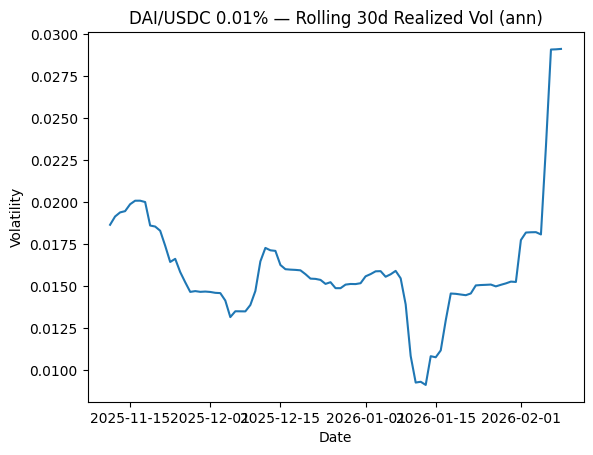

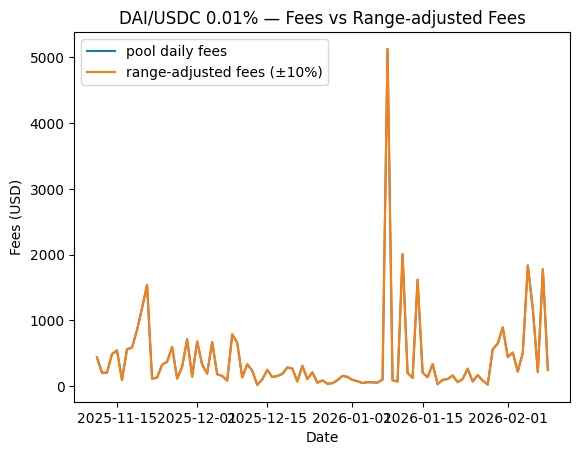

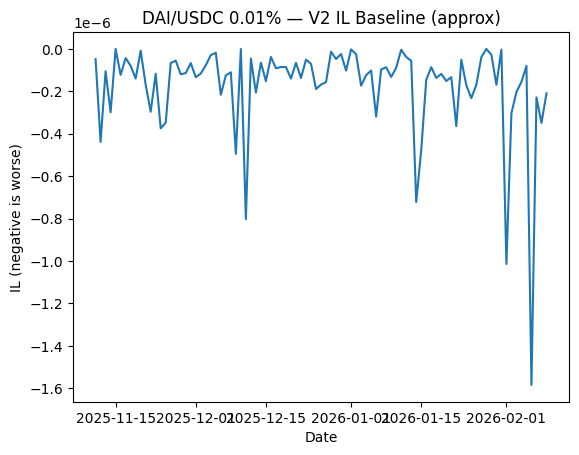

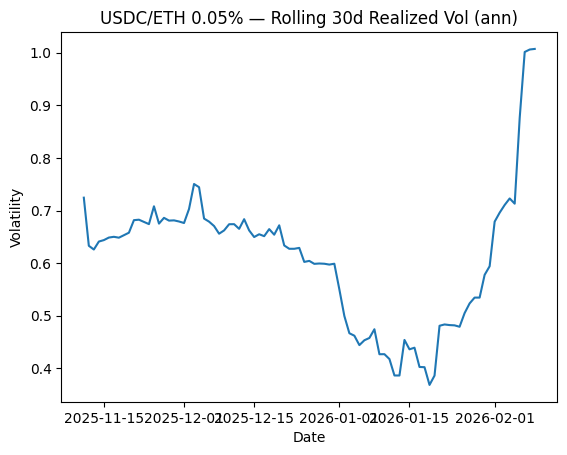

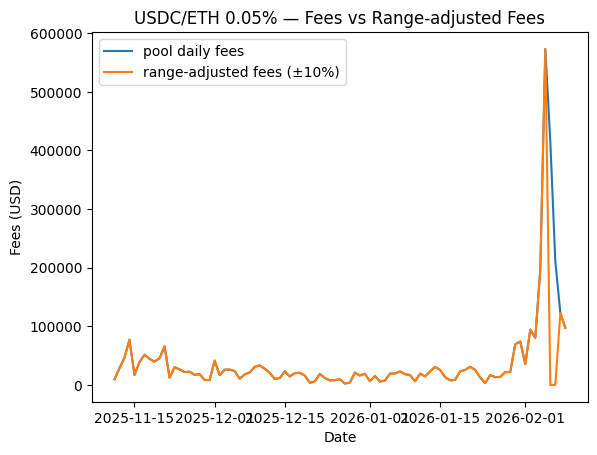

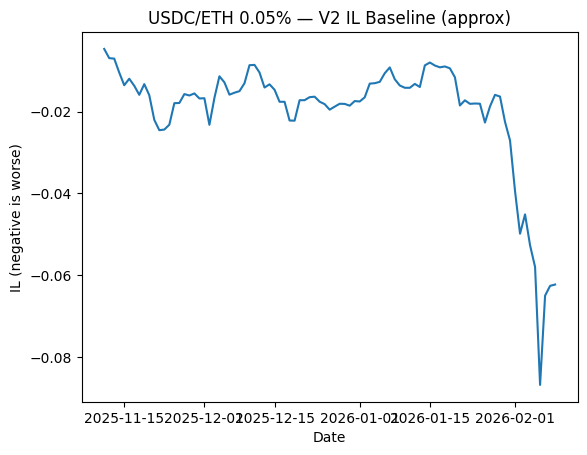

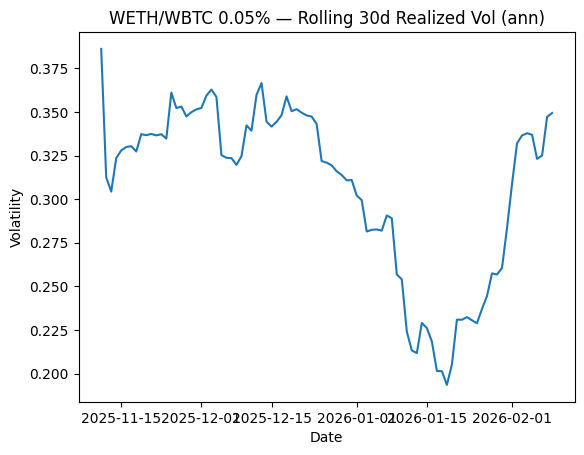

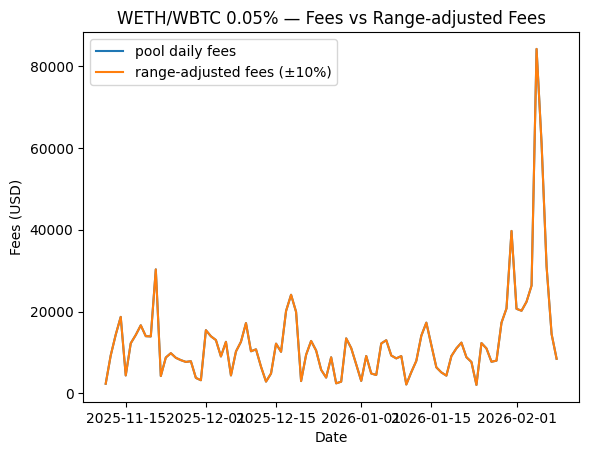

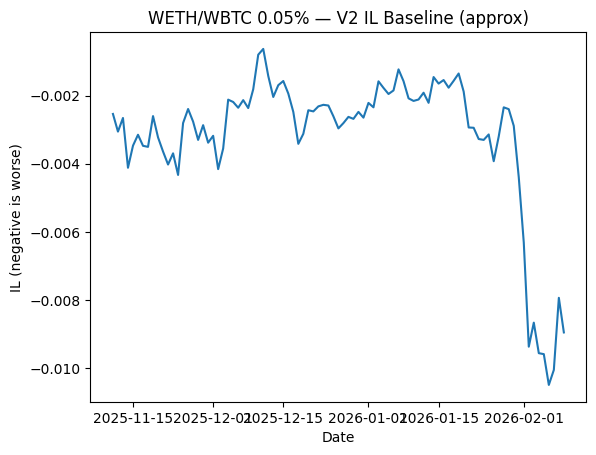

In [32]:
# C3) IL baseline (V2 approximation) + link fees vs vol
# Outputs:
#   - For each pool: IL series (vs start), and summary stats
#   - Plot: rolling vol vs daily fees (and range-adjusted fees)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def v2_il_from_ratio(R: pd.Series) -> pd.Series:
    # IL(R) = 2*sqrt(R)/(1+R) - 1
    return (2*np.sqrt(R)/(1+R)) - 1

# Build IL series for each pool based on price proxy
il_parts = []
for pool, col in pool_cols.items():
    tmp = prices[["date", col]].dropna().sort_values("date").rename(columns={col:"P"}).reset_index(drop=True)
    P0 = float(tmp["P"].iloc[0])
    tmp["R"] = tmp["P"] / P0
    tmp["IL_v2_baseline"] = v2_il_from_ratio(tmp["R"])
    tmp["pool_name"] = pool
    il_parts.append(tmp[["date","pool_name","P","IL_v2_baseline"]])

IL = pd.concat(il_parts, ignore_index=True)

# Join IL with Dune fees (daily)
fees = df[["date","pool_name","estimated_fees_usd"]].copy()
fees["date"] = pd.to_datetime(fees["date"]).dt.normalize()

# Rolling vol (use your A function ann_realized_vol; here re-use quickly)
def ann_realized_vol(px: pd.Series, window: int, ann_factor: int = 365) -> pd.Series:
    r = np.log(px).diff()
    return r.rolling(window=window, min_periods=window).std(ddof=0) * np.sqrt(ann_factor)

vol_parts = []
for pool, col in pool_cols.items():
    tmp = prices[["date", col]].dropna().sort_values("date").rename(columns={col:"P"}).reset_index(drop=True)
    tmp["rv_30d_ann"] = ann_realized_vol(tmp["P"], 30)
    tmp["rv_90d_ann"] = ann_realized_vol(tmp["P"], 90)
    tmp["pool_name"] = pool
    vol_parts.append(tmp[["date","pool_name","rv_30d_ann","rv_90d_ann"]])

VOL = pd.concat(vol_parts, ignore_index=True)

# Merge to create C3 panel
panel = fees.merge(VOL, on=["date","pool_name"], how="left").merge(IL[["date","pool_name","IL_v2_baseline"]], on=["date","pool_name"], how="left")

# Also merge range-adjusted fees (pick one range for the story, e.g. ±10%)
range_pick = 0.10
range_adj = c[c["range_pct"]==range_pick][["date","pool_name","range_adjusted_fees"]].copy()
panel = panel.merge(range_adj, on=["date","pool_name"], how="left")

# Summary table (per pool)
C3_summary = (panel.groupby("pool_name")
              .agg(
                  avg_rv30=("rv_30d_ann","mean"),
                  avg_rv90=("rv_90d_ann","mean"),
                  worst_IL=("IL_v2_baseline","min"),
                  avg_daily_fees=("estimated_fees_usd","mean"),
                  avg_daily_range_adj_fees=("range_adjusted_fees","mean"),
              )
              .reset_index())

display(C3_summary)

# Plots: for each pool, show vol vs fees
for pool, g in panel.groupby("pool_name"):
    g = g.sort_values("date")

    plt.figure()
    plt.plot(g["date"], g["rv_30d_ann"])
    plt.title(f"{pool} — Rolling 30d Realized Vol (ann)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.show()

    plt.figure()
    plt.plot(g["date"], g["estimated_fees_usd"], label="pool daily fees")
    plt.plot(g["date"], g["range_adjusted_fees"], label=f"range-adjusted fees (±{int(range_pick*100)}%)")
    plt.title(f"{pool} — Fees vs Range-adjusted Fees")
    plt.xlabel("Date")
    plt.ylabel("Fees (USD)")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(g["date"], g["IL_v2_baseline"])
    plt.title(f"{pool} — V2 IL Baseline (approx)")
    plt.xlabel("Date")
    plt.ylabel("IL (negative is worse)")
    plt.show()

 DAI/USDC

    •	Rolling 30d realized vol (DAI/USDC): Volatility stays very low throughout (stablecoin behavior), with a modest uptick near the end of the window. Even the “spikes” are small in absolute terms, so price risk is not the main driver for this pool.
    •	Fees vs range-adjusted fees (±10%): The two lines almost fully overlap, meaning the ±10% band is effectively always in-range for DAI/USDC. Fee fluctuations are driven by changes in trading flow/volume (including a few large fee spikes), not by out-of-range effects.
    •	V2 IL baseline (approx): IL remains essentially near zero (note the micro-scale on the y-axis), confirming that impermanent loss for a stablecoin-stablecoin pair is negligible under a 50/50 V2 approximation. Any profitability discussion here is mostly about fee generation rather than IL risk.

USDC/ETH

	•	Rolling 30d realized vol: Volatility trends down into mid-January (a calmer regime), then rises sharply into early February, reaching a much higher level. This indicates a clear regime shift where price moves become larger and faster—exactly the environment where concentrated LP positions are more likely to drift out-of-range.
	•	Fees vs range-adjusted fees (±10%): Fees are relatively steady for most of the sample, then spike dramatically in early February. The range-adjusted series closely tracks pool fees on most days, but it drops to zero on a couple of high-fee days, showing that even when the pool is generating huge fees, a fixed ±10% range can miss them if price moves outside the band—fee capture is path-dependent.
	•	V2 IL baseline (approx): The IL baseline is mildly negative for much of the period, then becomes sharply more negative around the late-period sell-off, consistent with large directional moves in ETH vs USDC. This supports the risk narrative: the same high-vol regime that boosts trading/fees also increases IL and out-of-range risk, so “high fees” do not automatically translate into strong LP net performance.


WETH/WBTC

	•	Rolling 30d realized vol: Volatility sits in a moderate band, declines into mid-January (quieter relative-price regime), then rebounds into early February. Compared with USDC/ETH, this is a “mid-risk” profile because ETH and BTC are highly correlated, so the ratio moves less than ETH/USD.
	•	Fees vs range-adjusted fees (±10%): The two lines almost fully overlap, meaning the ±10% range proxy stays in-range for nearly all days in this sample. Fees still show spikes (flow-driven), but out-of-range fee loss is minimal here versus USDC/ETH.
	•	V2 IL baseline (approx): IL is mildly negative most of the time and becomes more negative near the end, indicating ETH/BTC relative moves widened. Still, the magnitude is much smaller than USDC/ETH’s IL baseline, consistent with “relative-value” risk being smaller than outright ETH/USD risk.



# Stress Test, Risk return for each pool, Regime shift

The following prepares the inputs for the V3 out-of-range proxy.
(1) build daily **pool price proxies** from CoinGecko (ETH/USD, DAI/USD ÷ USDC/USD, and ETH/USD ÷ WBTC/USD),
(2) aggregate Dune trades into **daily pool fees/volume/swaps** and pivot to a date×pool panel, and
(3) implement a **time-in-range indicator with weekly rebalancing** (resetting the range center every 7 days).

Compute **range-adjusted fees** by setting fees to zero on out-of-range days.

In [33]:
import numpy as np
import pandas as pd

# ---------- 0) Input: prices + df (Dune) ----------
# prices: columns expected: date, ETH_USD, WBTC_USD, DAI_USD, USDC_USD
# df: columns expected: date, pool_name, num_swaps, volume_usd, estimated_fees_usd

prices = prices.copy()
prices["date"] = pd.to_datetime(prices["date"]).dt.normalize()

df = df.copy()
df["date"] = pd.to_datetime(df["date"]).dt.normalize()

# ---------- 1) Define pool set ----------
POOLS = [
    "USDC/ETH 0.05%",
    "DAI/USDC 0.01%",
    "WETH/WBTC 0.05%",
]

# ---------- 2) Build pool "price proxy" series ----------
# USDC/ETH: use ETH_USD (USDC approx 1)
# DAI/USDC: use DAI_USD / USDC_USD (close to 1)
# WETH/WBTC: use ETH_USD / WBTC_USD  (ETH per BTC). Consistent ratio is what matters.
pool_px = pd.DataFrame({"date": prices["date"]})
pool_px["USDC/ETH 0.05%"] = prices["ETH_USD"]
pool_px["DAI/USDC 0.01%"] = prices["DAI_USD"] / prices["USDC_USD"]
pool_px["WETH/WBTC 0.05%"] = prices["ETH_USD"] / prices["WBTC_USD"]

# ---------- 3) Build daily pool fees from Dune ----------
pool_fees = (df[df["pool_name"].isin(POOLS)]
             .groupby(["date", "pool_name"], as_index=False)
             .agg(estimated_fees_usd=("estimated_fees_usd", "sum"),
                  volume_usd=("volume_usd", "sum"),
                  num_swaps=("num_swaps", "sum")))

# pivot to date x pool
fees_wide = pool_fees.pivot(index="date", columns="pool_name", values="estimated_fees_usd").sort_index()
fees_wide = fees_wide.reindex(pool_px["date"]).reset_index(drop=True)
fees_wide.insert(0, "date", pool_px["date"])

# ---------- 4) Helpers ----------
def time_in_range(px: pd.Series, band: float, rebalance_days: int = 7) -> pd.Series:
    """
    In-range indicator with periodic rebalance.
    Every `rebalance_days`, reset center price to current price.
    """
    px = px.copy()
    ind = pd.Series(0.0, index=px.index)

    s = px.dropna()
    if s.empty:
        return ind

    # Work on non-NaN positions only
    idx = s.index
    vals = s.values

    start = 0
    while start < len(vals):
        center = vals[start]
        lo, hi = center * (1 - band), center * (1 + band)

        end = min(start + rebalance_days, len(vals))
        window_idx = idx[start:end]
        window_vals = vals[start:end]

        ind.loc[window_idx] = ((window_vals >= lo) & (window_vals <= hi)).astype(float)
        start = end

    return ind

def range_adjusted_fees(fees: pd.Series, in_range: pd.Series) -> pd.Series:
    """
    Simple proxy: fees earned only when in-range; otherwise 0.
    """
    out = fees.copy()
    out = out.fillna(0.0) * in_range.fillna(0.0)
    return out

print("Prep done. pool_px columns:", pool_px.columns.tolist())
print("Prep done. fees_wide columns:", fees_wide.columns.tolist())

Prep done. pool_px columns: ['date', 'USDC/ETH 0.05%', 'DAI/USDC 0.01%', 'WETH/WBTC 0.05%']
Prep done. fees_wide columns: ['date', 'DAI/USDC 0.01%', 'USDC/ETH 0.05%', 'WETH/WBTC 0.05%']


##Stress Test:
If there is shocks in market, apply the to price series, then recompute:

- time-in-range under different range strategies(5/10/20)
- range-adjusted fees
simple one sided exposure flag


This cell runs a lightweight **stress test** on the “range-adjusted fee capture” proxy. I define four shock scenarios (ETH -20%, correlation break, DAI depegs) by shifting the CoinGecko price paths, rebuild the pool price proxies under each scenario, and re-compute **time-in-range** and **range-adjusted fees** for ±5/±10/±20 ranges. The output ranks pool×range combinations by **fee_drop_pct** (how much fee capture is lost due to going out-of-range) and flags a simple **one-sided exposure** proxy based on where the price ends relative to the band.

In [34]:
import numpy as np
import pandas as pd

RANGES = [0.05, 0.10, 0.20]

def apply_scenario(prices_df: pd.DataFrame, scenario: str) -> pd.DataFrame:
    """
    Returns a copy of prices with scenario shock applied (entire series shift).
    This is a proxy: we shift the path to represent the shock environment.
    """
    p = prices_df.copy()

    if scenario == "ETH -20%":
        p["ETH_USD"] = p["ETH_USD"] * 0.80

    elif scenario == "Corr break (BTC -15%, ETH +5%)":
        p["WBTC_USD"] = p["WBTC_USD"] * 0.85
        p["ETH_USD"] = p["ETH_USD"] * 1.05

    elif scenario == "DAI depeg -1%":
        p["DAI_USD"] = p["DAI_USD"] * 0.99

    elif scenario == "DAI depeg -3%":
        p["DAI_USD"] = p["DAI_USD"] * 0.97

    else:
        raise ValueError("Unknown scenario")

    return p

def build_pool_px_from_prices(prices_df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({"date": pd.to_datetime(prices_df["date"]).dt.normalize()})
    out["USDC/ETH 0.05%"] = prices_df["ETH_USD"]
    out["DAI/USDC 0.01%"] = prices_df["DAI_USD"] / prices_df["USDC_USD"]
    out["WETH/WBTC 0.05%"] = prices_df["ETH_USD"] / prices_df["WBTC_USD"]
    return out

SCENARIOS = [
    "ETH -20%",
    "Corr break (BTC -15%, ETH +5%)",
    "DAI depeg -1%",
    "DAI depeg -3%",
]

# baseline fees per pool (same dates as pool_px)
fees_base = {pool: fees_wide[pool] for pool in POOLS}

rows = []
for scen in ["BASELINE"] + SCENARIOS:
    if scen == "BASELINE":
        px_s = pool_px.copy()
    else:
        shocked_prices = apply_scenario(prices, scen)
        px_s = build_pool_px_from_prices(shocked_prices)

    for pool in POOLS:
        px = px_s[pool]
        fees = fees_base[pool]

        for band in RANGES:
            inr = time_in_range(px, band)
            adj_f = range_adjusted_fees(fees, inr)

            # one-sided exposure proxy: end outside band?
            # compare last valid price to entry band
            s = px.dropna()
            if s.empty:
                side = "NA"
            else:
                p0 = s.iloc[0]
                lo, hi = p0*(1-band), p0*(1+band)
                plast = s.iloc[-1]
                if plast < lo:
                    side = "Below range (one-sided token1)"
                elif plast > hi:
                    side = "Above range (one-sided token0)"
                else:
                    side = "In range"

            rows.append({
                "scenario": scen,
                "pool": pool,
                "range_band": f"±{int(band*100)}%",
                "time_in_range": float(np.nanmean(inr.values)),
                "fees_total_usd": float(np.nansum(fees.values)),
                "range_adj_fees_total_usd": float(np.nansum(adj_f.values)),
                "fee_drop_pct": float(1 - (np.nansum(adj_f.values) / (np.nansum(fees.values) + 1e-12))),
                "ending_exposure": side
            })

stress_tbl = pd.DataFrame(rows)

# Show: per scenario, which pool/range loses fees most
stress_rank = (stress_tbl[stress_tbl["scenario"] != "BASELINE"]
               .sort_values(["scenario","fee_drop_pct"], ascending=[True, False])
               .groupby("scenario", as_index=False).head(6))

display(stress_rank)

,scenario,pool,range_band,time_in_range,fees_total_usd,range_adj_fees_total_usd,fee_drop_pct,ending_exposure
18,"Corr break (BTC -15%, ETH +5%)",USDC/ETH 0.05%,±5%,0.666667,3.629330e+06,1.800765e+06,0.503830,Below range (one-sided token1)
19,"Corr break (BTC -15%, ETH +5%)",USDC/ETH 0.05%,±10%,0.922222,3.629330e+06,2.802294e+06,0.227876,Below range (one-sided token1)
24,"Corr break (BTC -15%, ETH +5%)",WETH/WBTC 0.05%,±5%,0.966667,1.138454e+06,1.075209e+06,0.055553,Below range (one-sided token1)
20,"Corr break (BTC -15%, ETH +5%)",USDC/ETH 0.05%,±20%,0.988889,3.629330e+06,3.454759e+06,0.048100,Below range (one-sided token1)
25,"Corr break (BTC -15%, ETH +5%)",WETH/WBTC 0.05%,±10%,0.988889,1.138454e+06,1.095871e+06,0.037405,Below range (one-sided token1)
21,"Corr break (BTC -15%, ETH +5%)",DAI/USDC 0.01%,±5%,1.000000,3.728313e+04,3.728313e+04,0.000000,In range
27,DAI depeg -1%,USDC/ETH 0.05%,±5%,0.666667,3.629330e+06,1.800765e+06,0.503830,Below range (one-sided token1)
28,DAI depeg -1%,USDC/ETH 0.05%,±10%,0.922222,3.629330e+06,2.802294e+06,0.227876,Below range (one-sided token1)
33,DAI depeg -1%,WETH/WBTC 0.05%,±5%,0.966667,1.138454e+06,1.075209e+06,0.055553,Below range (one-sided token1)
29,DAI depeg -1%,USDC/ETH 0.05%,±20%,0.988889,3.629330e+06,3.454759e+06,0.048100,Below range (one-sided token1)


##Risk return


The following constructs a simple **risk–return frontier** for Uniswap V3 range strategies. For each pool and each band (±5/±10/±20), I compute **time-in-range** and build **range-adjusted daily fees** (fees earned only when in-range, otherwise 0). I then summarize each strategy by expected daily fees (mean), downside (5th percentile), and fee risk (std). The scatter plot visualizes the trade-off: higher expected fees typically come with higher fee volatility, enabling a structured comparison of pool×range strategy choices.

,pool,range_band,time_in_range,exp_daily_fees,downside_daily_fees_p5,fee_vol_std
4,DAI/USDC 0.01%,±10%,1.000000,207.128497,0.0,506.189558
5,DAI/USDC 0.01%,±20%,1.000000,207.128497,0.0,506.189558
3,DAI/USDC 0.01%,±5%,1.000000,207.128497,0.0,506.189558
1,USDC/ETH 0.05%,±10%,0.922222,15568.301130,0.0,49571.351156
2,USDC/ETH 0.05%,±20%,0.988889,19193.105215,0.0,57850.296575
0,USDC/ETH 0.05%,±5%,0.666667,10004.251272,0.0,45648.216017
7,WETH/WBTC 0.05%,±10%,0.988889,6088.170244,0.0,10141.667517
8,WETH/WBTC 0.05%,±20%,1.000000,6324.746808,0.0,10245.363070
6,WETH/WBTC 0.05%,±5%,0.966667,5973.385307,0.0,10092.883641


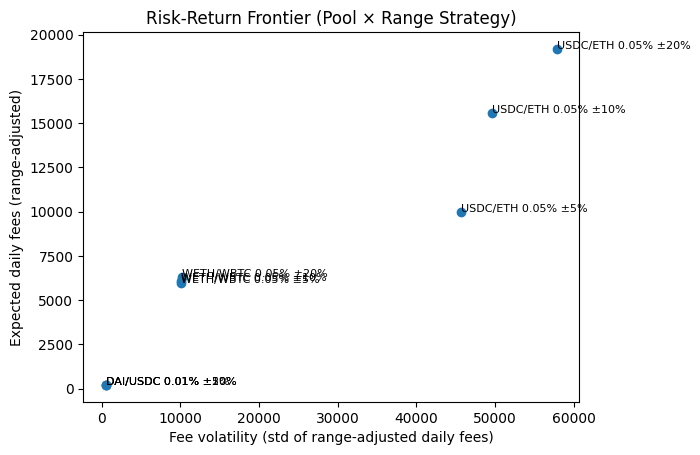

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANGES = [0.05, 0.10, 0.20]

frontier_rows = []
for pool in POOLS:
    px = pool_px[pool]
    fees = fees_wide[pool].fillna(0.0)

    for band in RANGES:
        inr = time_in_range(px, band)
        adj_daily = range_adjusted_fees(fees, inr)

        frontier_rows.append({
            "pool": pool,
            "range_band": f"±{int(band*100)}%",
            "time_in_range": float(inr.mean()),
            "exp_daily_fees": float(adj_daily.mean()),
            "downside_daily_fees_p5": float(adj_daily.quantile(0.05)),
            "fee_vol_std": float(adj_daily.std(ddof=0)),
        })

frontier = pd.DataFrame(frontier_rows).sort_values(["pool","range_band"])
display(frontier)

# Simple risk-return frontier plot: x = fee_vol, y = expected fees
plt.figure()
plt.scatter(frontier["fee_vol_std"], frontier["exp_daily_fees"])
for _, r in frontier.iterrows():
    plt.text(r["fee_vol_std"], r["exp_daily_fees"], f'{r["pool"]} {r["range_band"]}', fontsize=8)

plt.xlabel("Fee volatility (std of range-adjusted daily fees)")
plt.ylabel("Expected daily fees (range-adjusted)")
plt.title("Risk-Return Frontier (Pool × Range Strategy)")
plt.show()

Table:

	•	DAI/USDC 0.01% stays in-range 100% for all bands, so range choice barely changes expected fees (low return, low-moderate fee vol).
	•	USDC/ETH 0.05% shows the clearest range trade-off: tighter bands reduce time-in-range and expected fees; wider bands raise both, but fee volatility is still very high.
	•	WETH/WBTC 0.05% is mostly in-range even at ±5%, so widening the band doesn’t add much; expected fees sit in the middle with materially lower vol than USDC/ETH.
Plot (risk–return):

	•	The points line up as: USDC/ETH = highest return / highest risk, WETH/WBTC = mid return / mid risk, DAI/USDC = low return / low risk.
	•	Within USDC/ETH, moving from ±5% → ±20% pushes up/right (more fee capture, still very volatile), illustrating the core “higher fees come with higher variability” trade-off.

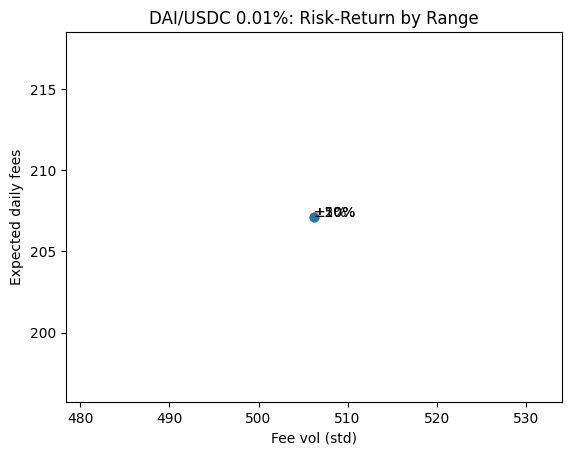

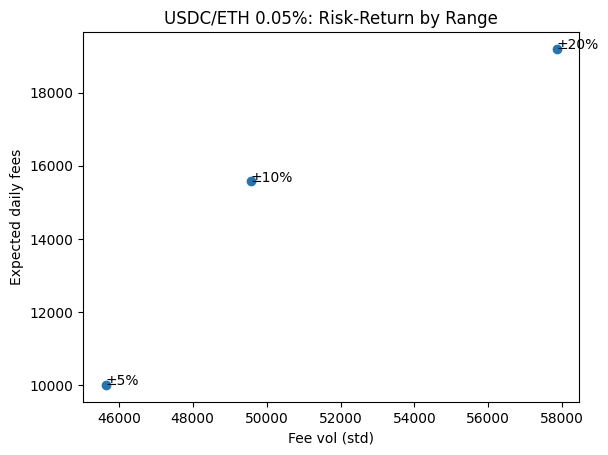

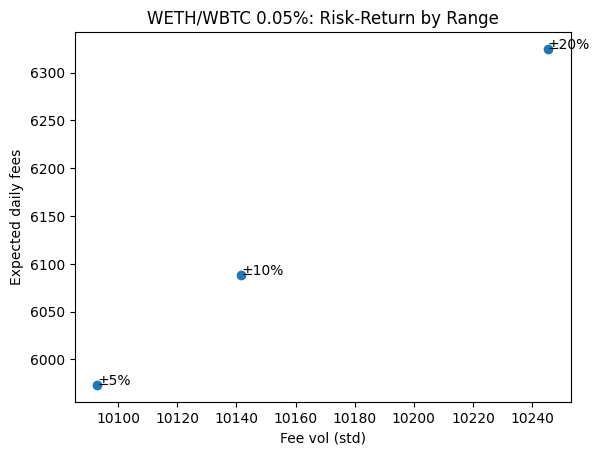

In [38]:
for pool in frontier["pool"].unique():
    sub = frontier[frontier["pool"] == pool]
    plt.figure()
    plt.scatter(sub["fee_vol_std"], sub["exp_daily_fees"])
    for _, r in sub.iterrows():
        plt.text(r["fee_vol_std"], r["exp_daily_fees"], r["range_band"], fontsize=10)
    plt.xlabel("Fee vol (std)")
    plt.ylabel("Expected daily fees")
    plt.title(f"{pool}: Risk-Return by Range")
    plt.show()

	•	DAI/USDC 0.01%: the three range points overlap almost perfectly, meaning range width barely matters here. Since the price stays very close to 1, LPs are almost always in-range, so expected fees and fee volatility don’t change much across ±5/±10/±20.
	•	USDC/ETH 0.05%: widening the range increases expected fees (more time in-range) but also increases fee volatility. The ±20% point sits highest and farthest right: higher average fee capture, but much more “regime-driven”/spiky fee outcomes.
	•	WETH/WBTC 0.05%: similar pattern to USDC/ETH but with smaller magnitude. Wider ranges improve expected fee capture modestly while pushing risk (fee vol) up slightly; the trade-off is gentler because ETH/BTC relative moves are typically less extreme than ETH/USD moves.

##Regime Shift

In [43]:
import numpy as np
import pandas as pd

def realized_vol_rolling(px: pd.Series, window: int = 14, ann_factor: int = 365) -> pd.Series:
    """
    Rolling annualized realized vol using log returns.
    """
    r = np.log(px).diff()
    return r.rolling(window).std(ddof=0) * np.sqrt(ann_factor)

WINDOW_VOL = 30

regime_rows = []
for pool in POOLS:
    px = pool_px[pool]
    fees = fees_wide[pool].fillna(0.0)

    # fee_rate needs volume; rebuild from pool_fees
    tmp = pool_fees[pool_fees["pool_name"] == pool].copy()
    tmp = tmp.sort_values("date")
    tmp["fee_rate"] = tmp["estimated_fees_usd"] / (tmp["volume_usd"] + 1e-12)

    # rolling vol + regime split
    vol = realized_vol_rolling(px, window=WINDOW_VOL)
    cutoff = vol.median(skipna=True)
    regime = np.where(vol >= cutoff, "HIGH_VOL", "LOW_VOL")

    # align to dates
    aligned = pd.DataFrame({
        "date": pool_px["date"],
        "fees": fees,
        "vol": vol,
        "regime": regime
    }).merge(tmp[["date","fee_rate"]], on="date", how="left")

    # time-in-range under a standard band (pick ±10% as “default”)
    band = 0.10
    aligned["in_range"] = time_in_range(px, band).values

    # summarize per regime
    for reg in ["LOW_VOL", "HIGH_VOL"]:
        sub = aligned[aligned["regime"] == reg].dropna(subset=["vol"])
        if len(sub) == 0:
            continue
        regime_rows.append({
            "pool": pool,
            "regime": reg,
            "days": len(sub),
            "vol_median": float(sub["vol"].median()),
            "fees_mean": float(sub["fees"].mean()),
            "fees_p10": float(sub["fees"].quantile(0.10)),
            "fee_rate_mean": float(sub["fee_rate"].mean(skipna=True)),
            "in_range_mean(±10%)": float(sub["in_range"].mean()),
        })

regime_tbl = pd.DataFrame(regime_rows).sort_values(["pool","regime"])
display(regime_tbl)

,pool,regime,days,vol_median,fees_mean,fees_p10,fee_rate_mean,in_range_mean(±10%)
3,DAI/USDC 0.01%,HIGH_VOL,75,0.020664,192.478454,0.000000,0.0001,1.000000
2,DAI/USDC 0.01%,LOW_VOL,75,0.014877,304.629939,0.000000,0.0001,1.000000
1,USDC/ETH 0.05%,HIGH_VOL,75,0.791109,28417.109900,0.000000,0.0005,0.880000
0,USDC/ETH 0.05%,LOW_VOL,75,0.577671,19973.956986,907.069765,0.0005,0.933333
5,WETH/WBTC 0.05%,HIGH_VOL,75,0.380106,2672.058100,0.000000,0.0005,1.000000
4,WETH/WBTC 0.05%,LOW_VOL,75,0.315942,12507.334238,2938.423494,0.0005,0.973333


Choose USDC/ETH pool analyze, as USDC/ETH is a canonical ‘volatile asset vs stablecoin’ pool on Uniswap v3; it isolates price risk in ETH, making it a clean testbed for linking volatility regimes to fee generation, IL baseline, and out-of-range fee capture.

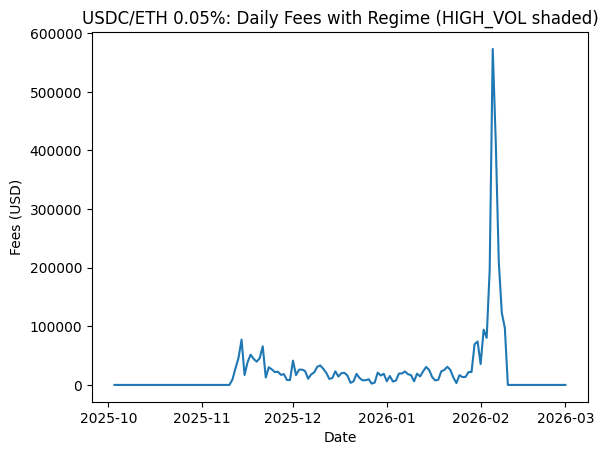

In [44]:
#graph 1
import matplotlib.pyplot as plt

pool = "USDC/ETH 0.05%"

px = pool_px[pool]
fees = fees_wide[pool].fillna(0.0)

vol = realized_vol_rolling(px, window=WINDOW_VOL)
cutoff = vol.median(skipna=True)
regime = np.where(vol >= cutoff, "HIGH_VOL", "LOW_VOL")

aligned = pd.DataFrame({
    "date": pool_px["date"],
    "fees": fees,
    "vol": vol,
    "regime": regime
}).dropna(subset=["vol"]).sort_values("date")

# shade HIGH_VOL days
plt.figure()
plt.plot(aligned["date"], aligned["fees"], label="daily fees")
for _, row in aligned.iterrows():
    if row["regime"] == "HIGH_VOL":
        plt.axvspan(row["date"], row["date"], alpha=0.02)  # light shading

plt.title(f"{pool}: Daily Fees with Regime (HIGH_VOL shaded)")
plt.xlabel("Date")
plt.ylabel("Fees (USD)")
plt.show()

Daily fees are mostly in a “normal range” for long stretches, but a single late-period spike dominates the series. That pattern suggests fees are highly event-driven (vol/liquidity shocks → activity bursts).


/tmp/ipython-input-1043/3693006806.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([low, high], labels=["LOW_VOL", "HIGH_VOL"], showfliers=False)


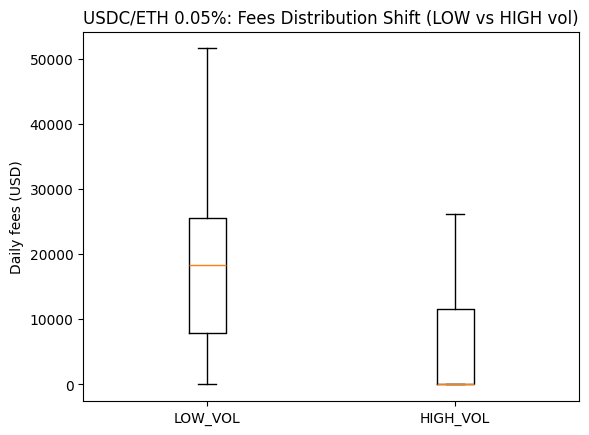

In [45]:
#graph 2
import matplotlib.pyplot as plt

pool = "USDC/ETH 0.05%"

px = pool_px[pool]
fees = fees_wide[pool].fillna(0.0)

vol = realized_vol_rolling(px, window=WINDOW_VOL)
cutoff = vol.median(skipna=True)
regime = np.where(vol >= cutoff, "HIGH_VOL", "LOW_VOL")

aligned = pd.DataFrame({
    "date": pool_px["date"],
    "fees": fees,
    "vol": vol,
    "regime": regime
}).dropna(subset=["vol"])

high = aligned.loc[aligned["regime"]=="HIGH_VOL", "fees"]
low  = aligned.loc[aligned["regime"]=="LOW_VOL", "fees"]

plt.figure()
plt.boxplot([low, high], labels=["LOW_VOL", "HIGH_VOL"], showfliers=False)
plt.title(f"{pool}: Fees Distribution Shift (LOW vs HIGH vol)")
plt.ylabel("Daily fees (USD)")
plt.show()

The boxplot shows higher typical fees (higher median) and wider dispersion in LOW_VOL, while HIGH_VOL has a low median with a tighter box—meaning many high-volatility days did not translate into consistently high fee capture, which shows a protocol-risk point: higher volatility does not guarantee LP fee income, because out-of-range behavior, liquidity re-positioning, and market microstructure effects can reduce realized fee capture even when volatility is elevated.

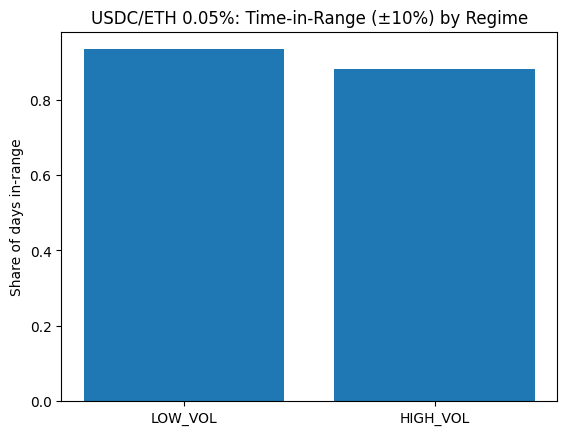

,date,vol,regime,in_range
30,2025-10-03,0.526564,LOW_VOL,1.0
31,2025-10-04,0.518258,LOW_VOL,1.0
32,2025-10-05,0.503729,LOW_VOL,1.0
33,2025-10-06,0.503985,LOW_VOL,1.0
34,2025-10-07,0.517711,LOW_VOL,0.0


Rows after dropna(vol): 150


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pool = "USDC/ETH 0.05%"
band = 0.10

px = pool_px[pool]
vol = realized_vol_rolling(px, window=WINDOW_VOL)
cutoff = vol.median(skipna=True)
regime = np.where(vol >= cutoff, "HIGH_VOL", "LOW_VOL")

# build aligned WITHOUT dropping first
aligned = pd.DataFrame({
    "date": pool_px["date"],
    "vol": vol,
    "regime": regime,
    "in_range": time_in_range(px, band)
})

# now dropna once so all columns align
aligned = aligned.dropna(subset=["vol"]).sort_values("date")

by_reg = aligned.groupby("regime")["in_range"].mean().reindex(["LOW_VOL", "HIGH_VOL"])

plt.figure()
plt.bar(by_reg.index, by_reg.values)
plt.title(f"{pool}: Time-in-Range (±{int(band*100)}%) by Regime")
plt.ylabel("Share of days in-range")
plt.show()

display(aligned.head())
print("Rows after dropna(vol):", len(aligned))

Plot (Time-in-Range ±10% by regime):
USDC/ETH stays in-range most of the time in both regimes, but LOW_VOL is slightly higher than HIGH_VOL. That’s consistent with the intuition: when volatility is higher, price is more likely to drift outside a fixed band, reducing fee-earning time.

Table (sample rows):
Each row is a day-level label showing the rolling vol, the assigned regime, and whether the pool was in_range (1) or out_of_range (0) for ±10%. The presence of some in_range = 0 days (even in LOW_VOL) shows that out-of-range is episodic—it can happen even when the overall regime isn’t extreme.